# Landsat 8 NDVI Analysis on the Cloud

This notebook demonstrates a "Cloud Native" analysis of [Normalized Difference Vegetation Index (NDVI)](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index) using [Landsat 8 satellite imagery](https://landsat.usgs.gov/landsat-8). 

**To run, simply hit Shift+Enter to run each code block**

By "Cloud Native" we mean that images are not downloaded to your local machine. Instead, calculations are performed efficiently in parallel across many distributed machines on Google Cloud ([where the imagery is stored](https://cloud.google.com/storage/docs/public-datasets/landsat)).

This workflow is possible because the Landsat 8 data is stored in [Cloud-Optimized Geotiff](http://www.cogeo.org) format, which can be accessed remotely via [xarray](http://xarray.pydata.org/en/stable/) and [rasterio](https://rasterio.readthedocs.io/en/latest/) Python libraries. Interactive, dynamically updating visualization is done with [Holoviews](http://holoviews.org). Distributed computing is enabled through a [Pangeo](http://pangeo.io) JupyterHub deployment with [Dask Kubernetes](https://github.com/dask/dask-kubernetes).

Created on August 30, 2018 by:

Scott Henderson, Daniel Rothenberg, Matthew Rocklin, Rich Signell, Joe Hamman, Ryan Abernathey, and Rob Fatland

In [1]:
# Import required libraries
import os
import pandas as pd
import rasterio
import xarray as xr
import requests
#import geoviews as gv
#import holoviews as hv
import hvplot.xarray
#import hvplot.pandas
#import shapely

import dask
from dask_kubernetes import KubeCluster
from dask.distributed import Client
from dask.distributed import wait, progress

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Print package versions
print('Xarray version: ', xr.__version__)
print('Rasterio version: ', rasterio.__version__)
print('dask version: ', dask.__version__)
print('hvplot version: ', hvplot.__version__)

Xarray version:  0.11.0
Rasterio version:  1.0.10
dask version:  0.20.2
hvplot version:  0.2.1


In [3]:
# Set environment variables for cloud-optimized-geotiffs efficiency
os.environ['GDAL_DISABLE_READDIR_ON_OPEN']='YES'
os.environ['CPL_VSIL_CURL_ALLOWED_EXTENSIONS']='TIF'
os.environ['CURL_CA_BUNDLE']='/etc/ssl/certs/ca-certificates.crt'

## Use NASA Common Metadata Repository (CMR) to get Landsat 8 images

[NASA CMR](https://earthdata.nasa.gov/about/science-system-description/eosdis-components/common-metadata-repository) is a new unified way to search for remote sensing assests across many archive centers. If you prefer a graphical user interface, NASA [Earthdata Search](https://search.earthdata.nasa.gov/search) is built on top of CMR. CMR returns download links through the USGS (https://earthexplorer.usgs.gov), but the same archive is mirrored as a (Google Public Dataset)[https://cloud.google.com/storage/docs/public-datasets/landsat], so we'll make a function that queries CMR and returns URLs to the imagery stored on Google Cloud.

In [4]:
def query_cmr_landsat(collection='Landsat_8_OLI_TIRS_C1',tier='T1', path=47, row=27):
    """Query NASA CMR for Collection1, Tier1 Landsat scenes from a specific path and row."""
    
    data = [f'short_name={collection}',
            f'page_size=2000',
            f'attribute[]=string,CollectionCategory,{tier}',
            f'attribute[]=int,WRSPath,{path}',
            f'attribute[]=int,WRSRow,{row}',
           ]

    query = 'https://cmr.earthdata.nasa.gov/search/granules.json?' + '&'.join(data)

    r = requests.get(query, timeout=100)
    print(r.url)
    
    df = pd.DataFrame(r.json()['feed']['entry'])
    
    # Save results to a file
    #print('Saved results to cmr-result.json')
    #with open('cmr-result.json', 'w') as j:
    #    j.write(r.text)
    
    return df

In [5]:
def make_google_archive(pids, bands):
    """Turn list of product_ids into pandas dataframe for NDVI analysis."""
    
    path =  pids[0].split('_')[2][1:3]
    row =  pids[0].split('_')[2][-2:]
    baseurl = f'https://storage.googleapis.com/gcp-public-data-landsat/LC08/01/0{path}/0{row}'
    
    dates = [pd.to_datetime(x.split('_')[3]) for x in pids]
    df = pd.DataFrame(dict(product_id=pids, date=dates))
    
    for band in bands:
        df[band] = [f'{baseurl}/{x}/{x}_{band}.TIF' for x in pids]
    
    return df

In [6]:
# Landsat scenes over a specific area are categorized by Path and Row
df = query_cmr_landsat(path=47, row=27)

https://cmr.earthdata.nasa.gov/search/granules.json?short_name=Landsat_8_OLI_TIRS_C1&page_size=2000&attribute[]=string,CollectionCategory,T1&attribute[]=int,WRSPath,47&attribute[]=int,WRSRow,27


In [7]:
# Add shapely and geoviews for this

# Holoviews maps are interactive, you can zoom in with the magnifying glass tool
#coordlist = df.polygons.iloc[0]
#lats = coordlist[0][0].split(' ')[::2]
#lons = coordlist[0][0].split(' ')[1::2]
#coords = [(float(lon),float(lat)) for lon, lat in zip(lons,lats)]
#poly = shapely.geometry.Polygon(coords)
#buffer = 1 #degrees
#left, bottom, right, top  = poly.bounds

#footprint = gv.Shape(poly, label=df.title.iloc[0]).options(alpha=0.5)
#tiles = gv.tile_sources.CartoEco.options(width=700, height=500).redim.range(Latitude=(bottom-1, top+1), Longitude=(left-1,right+1)) 
#labels = gv.tile_sources.StamenLabels.options(level='annotation')
#tiles * footprint * labels

In [8]:
# Get all scenes for a given path and row, bands 4 and 5
pids = df.title.tolist()
# Don't use the most recent date since there can be a lag in data being on Google Storage
df = make_google_archive(pids[:-1], ['B4', 'B5'])

In [9]:
#df.head()
df.tail()

,product_id,date,B4,B5
95,LC08_L1TP_047027_20180724_20180731_01_T1,2018-07-24,https://storage.googleapis.com/gcp-public-data...,https://storage.googleapis.com/gcp-public-data...
96,LC08_L1TP_047027_20180809_20180815_01_T1,2018-08-09,https://storage.googleapis.com/gcp-public-data...,https://storage.googleapis.com/gcp-public-data...
97,LC08_L1TP_047027_20180910_20180927_01_T1,2018-09-10,https://storage.googleapis.com/gcp-public-data...,https://storage.googleapis.com/gcp-public-data...
98,LC08_L1TP_047027_20180926_20181009_01_T1,2018-09-26,https://storage.googleapis.com/gcp-public-data...,https://storage.googleapis.com/gcp-public-data...
99,LC08_L1TP_047027_20181012_20181030_01_T1,2018-10-12,https://storage.googleapis.com/gcp-public-data...,https://storage.googleapis.com/gcp-public-data...


In [10]:
# Load with rasterio
image_url = df.iloc[0]['B4']
with rasterio.open(image_url) as src:
    print(src.profile)

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 7751, 'height': 7531, 'count': 1, 'crs': CRS({'init': 'epsg:32610'}), 'transform': Affine(30.0, 0.0, 356685.0,
       0.0, -30.0, 5367615.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}


<xarray.DataArray (band: 1, y: 7531, x: 7751)>
dask.array<shape=(1, 7531, 7751), dtype=uint16, chunksize=(1, 2048, 2048)>
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 5.368e+06 5.368e+06 5.368e+06 ... 5.142e+06 5.142e+06
  * x        (x) float64 3.567e+05 3.567e+05 3.568e+05 ... 5.892e+05 5.892e+05
Attributes:
    transform:   (30.0, 0.0, 356685.0, 0.0, -30.0, 5367615.0)
    crs:         +init=epsg:32610
    res:         (30.0, 30.0)
    is_tiled:    1
    nodatavals:  (nan,)


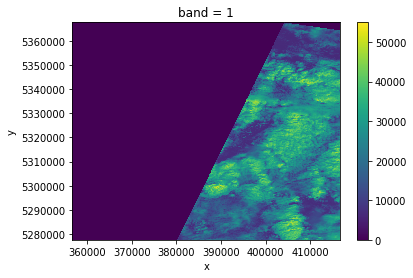

In [11]:
# Things working fine w/o dask distributed.
# Load with rasterio
image_url = df.iloc[0]['B4']
xchunk = 2048
ychunk = 2048
# instead of rasterio session set global os environment variables

#with rasterio.open(image_url) as src:
#    print(src.profile)
da = xr.open_rasterio(image_url, chunks={'band': 1, 'x': xchunk, 'y': ychunk})
print(da)
da.isel(band=0, x=slice(0,2000), y=slice(0,3000)).plot.imshow(center=False)

## Launch Dask Kubernetes Cluster

This will allow us to distribute our analysis across many machines. In the default configuration for Pangeo Binder, each worker has 2 vCPUs and 7Gb of RAM. It may take several minutes to initialize these workers and make them available to Dask.

In [12]:
# Select 10 'workers' under 'manual scaling' menu below and click 'Scale'
# Click on the 'Dashboard link' to monitor calculation progress
cluster = KubeCluster(n_workers=10)
cluster

In [13]:
# Attach Dask to the cluster
client = Client(cluster)

## Examine a single band Landsat image

The *rasterio* library allows us to read Geotiffs on the web without downloading the entire image. *Xarray* has a built-in load_rasterio() function that allows us to open the file as a DataArray. Xarray also uses Dask for lazy reading, so we want to make sure the native block tiling of the image matches the dask "chunk size". These dask chunks are automatically distributed among all our workers when a computation is requested, so ideally they will fit in the worker memory. A chunk size of 2048x2048 with a float32 datatype implies a 16Mb array.


In [14]:
# Load with rasterio
image_url = df.iloc[0]['B4']
with rasterio.open(image_url) as src:
    print(src.profile)

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 7751, 'height': 7531, 'count': 1, 'crs': CRS({'init': 'epsg:32610'}), 'transform': Affine(30.0, 0.0, 356685.0,
       0.0, -30.0, 5367615.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}


In [15]:
# Note that the blocksize of the image is 256 by 256, so we want xarray to use some multiple of that
xchunk = 2048
ychunk = 2048
da = xr.open_rasterio(image_url, chunks={'band': 1, 'x': xchunk, 'y': ychunk})
da

<xarray.DataArray (band: 1, y: 7531, x: 7751)>
dask.array<shape=(1, 7531, 7751), dtype=uint16, chunksize=(1, 2048, 2048)>
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 5.368e+06 5.368e+06 5.368e+06 ... 5.142e+06 5.142e+06
  * x        (x) float64 3.567e+05 3.567e+05 3.568e+05 ... 5.892e+05 5.892e+05
Attributes:
    transform:   (30.0, 0.0, 356685.0, 0.0, -30.0, 5367615.0)
    crs:         +init=epsg:32610
    res:         (30.0, 30.0)
    is_tiled:    1
    nodatavals:  (nan,)

In [16]:
# Load with rasterio
image_url = df.iloc[0]['B4']
xchunk = 2048
ychunk = 2048
# instead of rasterio session set global os environment variables

#with rasterio.open(image_url) as src:
#    print(src.profile)
da = xr.open_rasterio(image_url, chunks={'band': 1, 'x': xchunk, 'y': ychunk})
print(da)
da.isel(band=0, x=slice(0,2000), y=slice(0,3000)).plot.imshow(center=False)

<xarray.DataArray (band: 1, y: 7531, x: 7751)>
dask.array<shape=(1, 7531, 7751), dtype=uint16, chunksize=(1, 2048, 2048)>
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 5.368e+06 5.368e+06 5.368e+06 ... 5.142e+06 5.142e+06
  * x        (x) float64 3.567e+05 3.567e+05 3.568e+05 ... 5.892e+05 5.892e+05
Attributes:
    transform:   (30.0, 0.0, 356685.0, 0.0, -30.0, 5367615.0)
    crs:         +init=epsg:32610
    res:         (30.0, 30.0)
    is_tiled:    1
    nodatavals:  (nan,)


RasterioIOError: CURL error: error setting certificate verify locations:   CAfile: /etc/pki/tls/certs/ca-bundle.crt   CApath: none

### holoviews visualization
If we request to compute something or plot these arrays, the necessary data chunks will be accessed on cloud storage. Watch the KubeCluster dashboard to see the worker activity when this command is run. Note that no data is stored on the disk here, it's all in memory

Use the magnifying glass button on the right to interactively zoom in. The image resolution automatically updates based on zoom level. The cursor gives you UTM coordinates and the image value at that point!

In [14]:
band1 = da.sel(band=1).persist()
img = band1.hvplot(rasterize=True, dynamic=True, width=700, height=500, cmap='magma')
img

:DynamicMap   []
   :Image   [x,y]   (value)

## Load all Landsat bands into an xarray dataset

Often we want to analyze a time series of satellite imagery, but we are constrained by computational resources. So we either download all the images, extract a small subset and then do our analysis. Or, we coarsen the resolution of all our images so that the entire set fits into our computer RAM. Because this notebook is running on Google Cloud with access to many resources in our Kube Cluster, we no longer have to worry about the computational constraints, and can conduct our analysis at full resoution!

First we need to construct an xarray dataset object (which has data variables 'band4' and 'band5' in a n-dimensional array with x-coordinates representing UTM easting, y-coordinates representing UTM northing, and a time coordinate representing the image acquisition date).

There are different ways to go about this, but we will load our images with a timestamp index since each image is taken on a different date. Typically, this is a chore if our images are not on the same grid to begin with, but xarray knows how to automatically align images based on their georeferenced coordinates.

In [ ]:
# Note that these landsat images are not necessarily the same shape or on the same grid:
for image_url in df.B4[:5]:
    with rasterio.open(image_url) as src:
        print(src.shape, src.bounds)

In [ ]:
def create_multiband_dataset(row, bands=['B4','B5'], chunks={'band': 1, 'x': 2048, 'y': 2048}):
    '''A function to load multiple landsat bands into an xarray dataset '''
    
    # Each image is a dataset containing both band4 and band5
    datasets = []
    for band in bands:
        url = row[band]
        da = xr.open_rasterio(url, chunks=chunks)
        da = da.squeeze().drop(labels='band')
        ds = da.to_dataset(name=band)
        datasets.append(ds)

    DS = xr.merge(datasets)
    
    return DS

In [ ]:
# Merge all acquisitions into a single large Dataset, this will take a minute
datasets = []
for i,row in df.iterrows():
    try:
        print('loading...', row.date)
        ds = create_multiband_dataset(row)
        datasets.append(ds)
    except Exception as e:
        print('ERROR loading, skipping acquistion!')
        print(e)

In [ ]:
# Create an xarray dataset
DS = xr.concat(datasets, dim=pd.DatetimeIndex(df.date.tolist(), name='time'))
print('Dataset size (Gb): ', DS.nbytes/1e9)
DS

### Note that xarray has automatically expanded the dimensions to include the maximum extents of all the images, also the chunksize has been automatically adjusted.

There is definitely some room for improvement here from a computational efficiency standpoint - in particular the dask chunks are no longer aligned with the image tiles. This is because each image starts at different coordinates and has different shapes, but xarray uses a single chunk size for the entire datasets. There will also be many zeros in this dataset, so future work could take advantage of sparse arrays. 

These points aside, our KubeCluster will automatically parallelize our computations for us, so we can not worry too much about optimal efficiency and just go ahead and run our analysis!

In [ ]:
# Again, only metadata is retrieved at this point, wich is why it's so quick!
da = DS.sel(time='2013-04-21')['B4']
print('Image size (Gb): ', da.nbytes/1e9)
da

## Distributed NDVI computations

Set up our NDVI dataset. Note that NDVI is not actually computed until we call the Dask compute(), persist(), or call other functions such as plot() that require actually operate on the data!

Because we now have a timeseries of images Holoviews automatically will add a time slider to our visualization! We add a 'SingleTap' features as well to keep track of interesting coordinates (by clicking on the image a white dot will appear and the coordinates are stored in the 'taps' list)

In [ ]:
NDVI = (DS['B5'] - DS['B4']) / (DS['B5'] + DS['B4'])
NDVI

In [ ]:
taps = []
def record_coords(x, y):
    if None not in [x,y]:
        taps.append([x, y])
    return hv.Points(taps)

In [ ]:
# NOTE: this will take a minute to load and is best viewed on a wide monitor
# the time slider can get hidden on small screens
img = NDVI.hvplot('x', 'y', groupby='time', dynamic=True, rasterize=True, width=700, height=500, cmap='magma')
tap = hv.streams.SingleTap(transient=True, source=img)
clicked_points = hv.DynamicMap(record_coords, streams=[tap])

img * clicked_points.options(size=10, color='w')

In [ ]:
# Points clicked are stored in the 'taps list'
if len(taps) == 0:
    taps = [(562370, 5312519)]

print('Selected points:')
taps

### Extract time series for region around point selected from map

This uses a buffer around a selected point and does monthly resampling and will probably take a minute or so to pull the necessary data and run computations

In [ ]:
xcen,ycen = taps[0]
buf = 5000  # look at point +/- 5km
ds = NDVI.sel(x=slice(xcen-buf,xcen+buf), y=slice(ycen-buf,ycen+buf))
timeseries = ds.resample(time='1MS').mean().persist()
# Store as pandas series
s = timeseries.to_series() 

In [ ]:
# Holoviews is also great for interative 2D plots
line = s.hvplot(width=700, height=300, legend=False)
points = s.hvplot.scatter(width=700, height=300, legend=False)
label = f'Mean NDVI: easting={xcen:g} , northing={ycen:g}'

(line * points).relabel(label)

### Plot subset of selected region at full resolution

In [ ]:
ds.sel(time=slice('2015-01-01', '2015-06-15')).plot.imshow('x', 'y', col='time', col_wrap=4, cmap='magma', vmin=0, vmax=1)

## In conclusion

* This notebook demonstrates the power of storing data publically in the Cloud as optimized geotiffs - scientists can conduct scalable analysis without downloading the data to a local machine. Only derived subsets and figures need to be downloaded!
* We used a crude NDVI calculation, designed to demonstrate the syntax and tools - a proper analysis should take into account cloud masks and other corrections